# Task-1

### Libraries and Given Dataset 

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
rs = np.random.get_state()
np.random.seed(45)
num_samples = 40
    
# Generate data
x1 = np.random.uniform(-1, 1, num_samples)
f_x = 3*x1 + 4
eps = np.random.randn(num_samples)
y = f_x + eps

### Linear Regression and MSE fuctions

In [2]:
def reg(x,theta_0,theta_1):
    return theta_1*x + theta_0
def mse(y_hat,y):
    return torch.mean((y_hat-y)**2)

## 1.1 

#### Use ```torch.autograd``` to find the true gradient on the above dataset using linear regression (in the form $\theta_1x + \theta_0$) for any given values of $(\theta_0,\theta_1)$.

In [3]:
x1_torch = torch.from_numpy(x1)
y_torch = torch.from_numpy(y)
theta_0 = torch.tensor(1.0,requires_grad=True)
theta_1 = torch.tensor(0.0, requires_grad=True)

y_hat = reg(x1_torch,theta_0,theta_1)
loss = mse(y_hat,y_torch)
loss.backward()
theta_0_true_grad = theta_0.grad.item()
theta_1_true_grad = theta_1.grad.item()
print('The True gradient values of theta_0, theta_1:',theta_0_true_grad,theta_1_true_grad)

The True gradient values of theta_0, theta_1: -5.447053909301758 -1.1946825981140137


## 1.2

#### Using the same $(\theta_0,\theta_1)$ as above, calculate the stochastic gradient for all points in the dataset. Then, find the average of all those gradients.

In [4]:
t0_stochastic_gradients = []
t1_stochastic_gradients = []
for i in range(num_samples):
    theta_0.grad = None
    theta_1.grad = None
    y_hat = reg(x1_torch[i],theta_0,theta_1)
    loss = mse(y_hat,y_torch[i])
    loss.backward()
    t0_stochastic_gradients.append(theta_0.grad.item())
    t1_stochastic_gradients.append(theta_1.grad.item())

t0_avg_grad = sum(t0_stochastic_gradients)/num_samples
t1_avg_grad = sum(t1_stochastic_gradients)/num_samples
print('The True gradient values of theta_0, theta_1:',theta_0_true_grad,theta_1_true_grad)
print('The average value of stochastic gradient of theta_0, theta_1 for all points in the dataset:',t0_avg_grad,t1_avg_grad)

The True gradient values of theta_0, theta_1: -5.447053909301758 -1.1946825981140137
The average value of stochastic gradient of theta_0, theta_1 for all points in the dataset: -5.447053959220648 -1.194682613387704


#### Show that the stochastic gradient is a good estimate of the true gradient.

In [5]:
print('The difference between avg of stochastic and true grad is',abs(theta_0_true_grad-t0_avg_grad),abs(theta_1_true_grad-t1_avg_grad))

The difference between avg of stochastic and true grad is 4.9918890354661016e-08 1.527369031251169e-08


## 1.3

Find the optimal loss using normal equation.

$\theta_{optimal} = (X^{T}X)^{-1}X^{T}y$

In [6]:
x1_normal = torch.cat([x1_torch.float().unsqueeze(1), torch.ones_like(x1_torch.float().unsqueeze(1))],dim=1)
y_normal = y_torch.float().unsqueeze(1)
# print(x1_normal.shape,y_normal.shape)
xt = torch.transpose(x1_normal,0,1)
# print(xt.shape)
xtx = torch.matmul(xt,x1_normal)
xtx_inverse = torch.inverse(xtx)
# print(xtx_inverse.shape)
xty = torch.matmul(xt,y_normal)
# print(xty.shape)
theta_opt = torch.matmul(xtx_inverse,xty)
print(f'the optimal thetas are {theta_opt[0][0]} and {theta_opt[1][0]}')
loss_opt = mse(reg(x1_torch,theta_opt[1][0],theta_opt[0][0]),y_torch)
print(loss_opt)

the optimal thetas are 2.6824686527252197 and 3.9507064819335938
tensor(0.5958, dtype=torch.float64)


#### Implement full-batch, mini-batch and stochastic gradient descent. Choose $\epsilon = 0.001$ for convergence criteria.

In [7]:
def full_batch_grad(x,y,theta_0,theta_1,lr = 0.01,epsilon = 0.001,epochs = 15,printf = False,loss_opt = torch.tensor(0.5958, dtype=torch.float64)):
    t0_hist = [theta_0.item()]
    t1_hist = [theta_1.item()]
    losses = []
    epoch = 1
    loss = torch.tensor(float('inf'))
    if epochs is not None:
        while True:
            y_hat = reg(x,theta_0,theta_1)
            loss = mse(y_hat,y)
            losses.append(loss.item())
            loss.backward()
            with torch.no_grad():
                theta_0.data = theta_0-lr*theta_0.grad
                theta_1.data = theta_1-lr*theta_1.grad

            t0_hist.append(theta_0.item())
            t1_hist.append(theta_1.item())
            # print(f'Epoch:{epoch}--> Loss:{loss.item()}')
            theta_0.grad.zero_()
            theta_1.grad.zero_()
            epoch += 1
            if epoch>=epochs:
                break
            # if epoch>=400 and epoch%50 == 0:
            #     if losses[-5:].count(losses[-1])== 5:
            #         break
            # if len(losses) >2:
            #     if abs(losses[-1]-losses[-2])<epsilon:
            #         break
    else:
        while True:
            y_hat = reg(x,theta_0,theta_1)
            loss = mse(y_hat,y)
            losses.append(loss.item())
            loss.backward()
            with torch.no_grad():
                theta_0.data = theta_0-lr*theta_0.grad
                theta_1.data = theta_1-lr*theta_1.grad

            t0_hist.append(theta_0.item())
            t1_hist.append(theta_1.item())
            # print(f'Epoch:{epoch}--> Loss:{loss.item()}')
            theta_0.grad.zero_()
            theta_1.grad.zero_()
            epoch += 1
            # if epoch>=400 and epoch%50 == 0:
            #     if losses[-5:].count(losses[-1])== 5:
            #         break
            if len(losses) >=2:
                if abs(losses[-1]-loss_opt)<epsilon:
                    break
                
    if printf is True:
        print(f'Full Batch Gradient Descent---->No of Epochs Caliculated:{epoch} Final loss:{losses[-1]}')
    return losses, theta_0.grad.item(), theta_1.grad.item(),t0_hist,t1_hist
def mini_batch_grad(x,y,theta_0,theta_1,lr = 0.01,batch_size = 2,epsilon = 0.001, epochs = 15,printf=False,loss_opt = torch.tensor(0.605, dtype=torch.float64)):
    num_samples = x.size(0)
    theta_0 = torch.tensor(0.0,requires_grad=True)
    theta_1 = torch.tensor(0.0,requires_grad=True)
    t0_hist = [theta_0.item()]
    t1_hist = [theta_1.item()]
    losses = []
    avg_epoch_loss = float('inf')
    num_samples_per_batch = num_samples//batch_size
    epoch = 1
    if epochs is not None:
        while True:
            batch = torch.randperm(num_samples)
            epoch_loss = 0
            for i in range(0,num_samples, batch_size):
                indice = batch[i:i+batch_size]
                mini_x,mini_y = x[indice],y[indice]
                mini_y_hat = reg(mini_x, theta_0,theta_1)
                loss = mse(mini_y_hat,mini_y)
                epoch_loss += loss.item()
                loss.backward()
                with torch.no_grad():
                    theta_0.data -= lr*theta_0.grad
                    theta_1.data -= lr*theta_1.grad

                t0_hist.append(theta_0.item())
                t1_hist.append(theta_1.item())
                theta_0.grad.zero_()
                theta_1.grad.zero_()
            avg_epoch_loss = epoch_loss/num_samples_per_batch
            losses.append(avg_epoch_loss)
            # print(f'Epoch:{epoch}--> Avg Epoch Loss:{avg_epoch_loss}')
            epoch += 1
            if epoch >=epochs:
                break
            # if epoch>=400 and epoch%50 == 0:
            #     if losses[-5:].count(losses[-1])== 5:
            #         break
            # if len(losses) >2:
            #     if abs(losses[-1]-losses[-2])<epsilon:
            #         break
    else:
        while True:
            batch = torch.randperm(num_samples)
            epoch_loss = 0
            for i in range(0,num_samples, batch_size):
                indice = batch[i:i+batch_size]
                mini_x,mini_y = x[indice],y[indice]
                mini_y_hat = reg(mini_x, theta_0,theta_1)
                loss = mse(mini_y_hat,mini_y)
                epoch_loss += loss.item()
                loss.backward()
                with torch.no_grad():
                    theta_0.data -= lr*theta_0.grad
                    theta_1.data -= lr*theta_1.grad
                theta_0.grad.zero_()
                theta_1.grad.zero_()

                t0_hist.append(theta_0.item())
                t1_hist.append(theta_1.item())
            avg_epoch_loss = epoch_loss/num_samples_per_batch
            losses.append(avg_epoch_loss)
            epoch += 1
            if epoch%100 == 0:
                print(f'Epoch:{epoch}--> Avg Epoch Loss(Mini):{avg_epoch_loss}')
            # if epoch>=400 and epoch%50 == 0:
            #     if losses[-5:].count(losses[-1])== 5:
            #         break
            if len(losses) >=2:
                if (losses[-1]-loss_opt)<epsilon:
                    break

    if printf is True:
        print(f'Mini Batch Gradient Descent---->No of Epochs Caliculated:{epoch} Final loss:{losses[-1]}')    
    return losses,theta_0.grad.item(),theta_1.grad.item(),t0_hist,t1_hist
    
def stochastic_grad(x, y,theta_0,theta_1, lr=0.01, epsilon=0.001, epochs= 15,printf= False,loss_opt = torch.tensor(0.5958, dtype=torch.float64)):
    num_samples = x.size(0)
    theta_0 = torch.tensor(0.0,requires_grad=True)
    theta_1 = torch.tensor(0.0,requires_grad=True)
    t0_hist = [theta_0.item()]
    t1_hist = [theta_1.item()]
    losses = []
    avg_epoch_loss = float('inf')
    epoch = 1
    if epochs is not None:
        while True:
            epoch_loss = 0
            for i in range(num_samples):
                y_hat = reg(x[i], theta_0,theta_1)
                loss =mse(y_hat, y[i])
                epoch_loss += loss.item()
                loss.backward()
                with torch.no_grad():
                    theta_0.data -= lr*theta_0.grad
                    theta_1.data -= lr*theta_1.grad

                t0_hist.append(theta_0.item())
                t1_hist.append(theta_1.item())
                theta_0.grad.zero_()
                theta_1.grad.zero_()
            avg_epoch_loss = epoch_loss/num_samples
            losses.append(avg_epoch_loss)
            # print(f'Epoch:{epoch}-->Avg Epoch Loss:{avg_epoch_loss}')
            epoch += 1
            if epoch>= epochs:
                break
            # if epoch>1000 and epoch%100 == 0:
            #     if losses[-5:].count(losses[-1])== 5:
            #         break
            # if len(losses) >2:
            #     if abs(losses[-1]-losses[-2])<epsilon:
            #         break
    else:
        while True:
            epoch_loss = 0
            for i in range(num_samples):
                y_hat = reg(x, theta_0,theta_1)
                loss =mse(y_hat, y)
                epoch_loss += loss.item()
                loss.backward()
                with torch.no_grad():
                    theta_0.data -= lr*theta_0.grad
                    theta_1.data -= lr*theta_1.grad
                t0_hist.append(theta_0.item())
                t1_hist.append(theta_1.item())
                theta_0.grad.zero_()
                theta_1.grad.zero_()
            avg_epoch_loss = epoch_loss/num_samples
            # print(f'Epoch:{epoch}-->Avg Epoch Loss:{avg_epoch_loss}')
            losses.append(avg_epoch_loss)
            epoch += 1
            # if epoch>=400 and epoch%50 == 0:
            #     if losses[-5:].count(losses[-1])== 5:
            #         break
            if len(losses) >=2:
                if losses[-1]-loss_opt<epsilon:
                    break

    
    if printf is True:
        print(f'Stochastic Gradient Descent---->No of Epochs Caliculated:{epoch} Final loss:{losses[-1]}')
    return losses, theta_0.grad.item(), theta_1.grad.item(),t0_hist,t1_hist

#### For Optimum Learning Rate

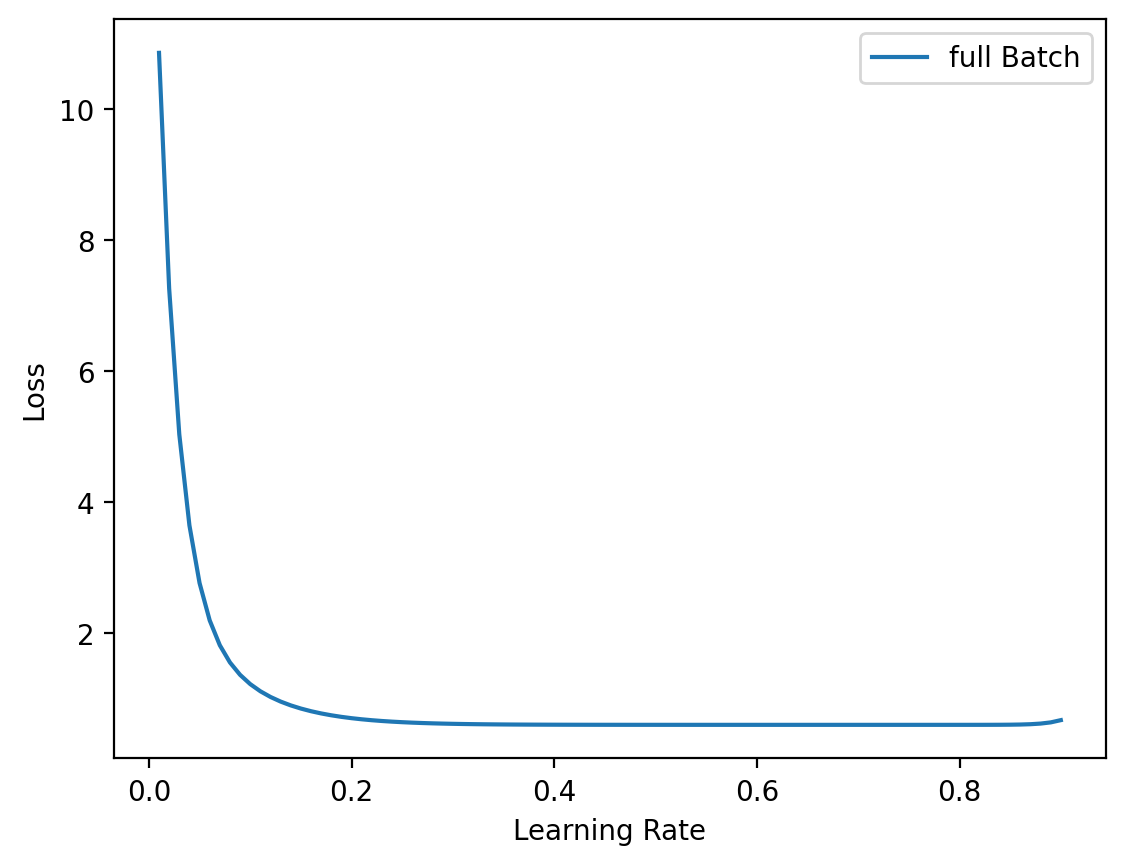

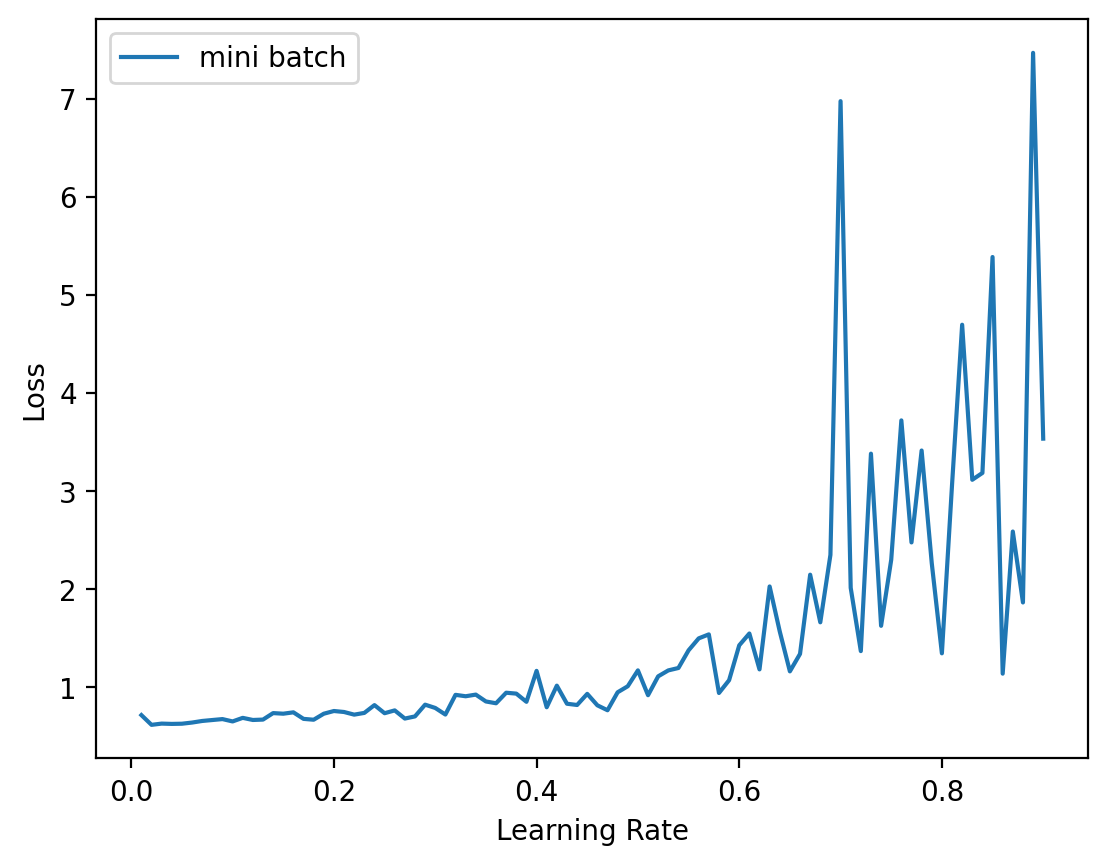

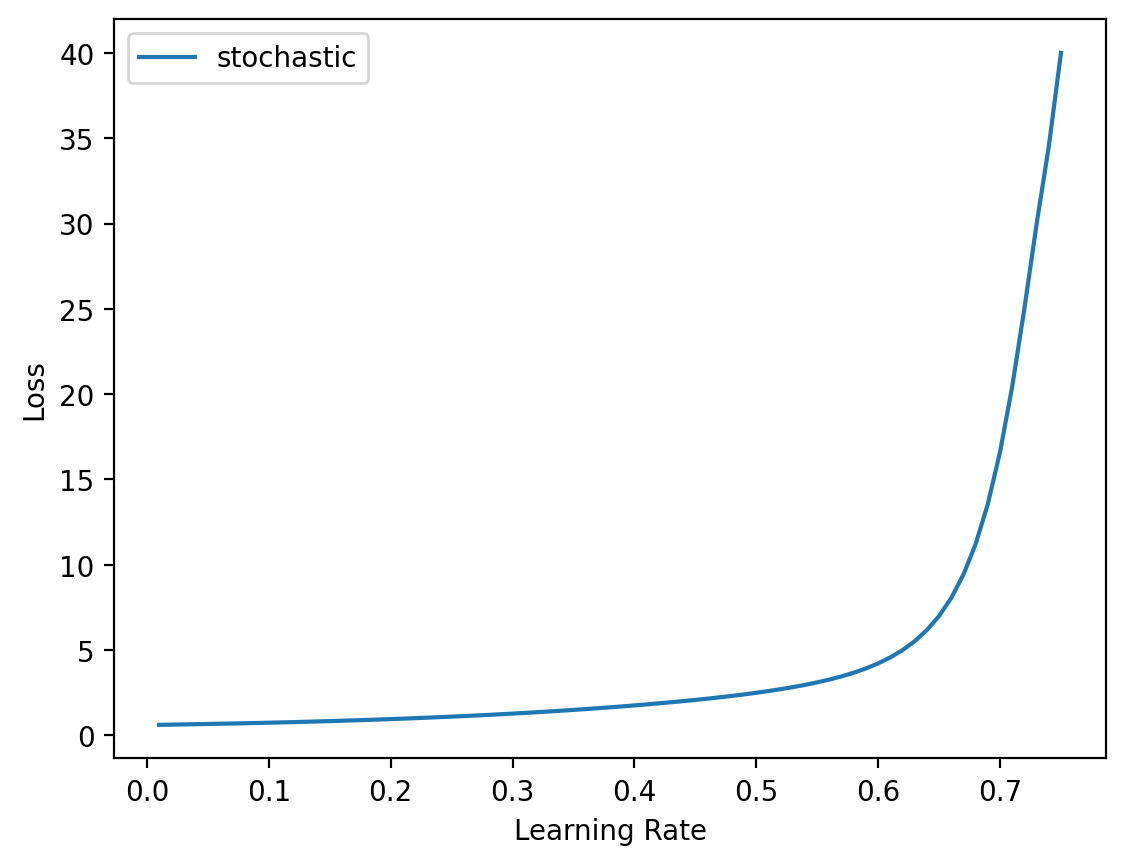

at Optimum lr:0.74, full batch has a loss of 0.5957547919676254
at Optimum lr:0.02, mini batch has a loss of 0.6125781518935773
at Optimum lr:0.01, stoc batch has a loss of 0.6141340064571434


In [8]:
learning_rates = np.arange(0.01,1,0.01)
loss_full= []
loss_mini = []
loss_stoc = []
for lr in learning_rates:
    theta_0 = torch.tensor(0.0,requires_grad=True)
    theta_1 = torch.tensor(0.0,requires_grad=True)
    # print(f'For learing rate {lr} :')
    losses_full,_,_,_,_= full_batch_grad(x1_torch, y_torch,theta_0,theta_1,lr =lr,epochs = 15)
    losses_mini,_,_,_,_= mini_batch_grad(x1_torch,y_torch,theta_0,theta_1,lr = lr,epochs = 15)
    losses_stoc,_,_,_,_= stochastic_grad(x1_torch,y_torch,theta_0,theta_1,lr = lr,epochs = 15)
    loss_full.append(losses_full[-1])
    loss_mini.append(losses_mini[-1])
    loss_stoc.append(losses_stoc[-1])

plt.plot(learning_rates[:90],loss_full[:90],label = 'full Batch')
plt.legend()  
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.show()
plt.plot(learning_rates[:90],loss_mini[:90], label = 'mini batch')
plt.legend()  
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.show()
plt.plot(learning_rates[:75],loss_stoc[:75], label = 'stochastic')
plt.legend()  
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.show()

i = np.argmin(loss_full)
j = np.argmin(loss_mini)
k = np.argmin(loss_stoc[:80])
opt_lr_full = learning_rates[i]
opt_lr_mini = learning_rates[j]
opt_lr_stoc = learning_rates[k]
# print(learning_rates)
print(f'at Optimum lr:{learning_rates[i]}, full batch has a loss of {loss_full[i]}')
print(f'at Optimum lr:{learning_rates[j]}, mini batch has a loss of {loss_mini[j]}')
print(f'at Optimum lr:{learning_rates[k]}, stoc batch has a loss of {loss_stoc[k]}')

#### Calculate the average number of iterations required for each method to get sufficiently close to the optimal solution, where "sufficiently close" means within a distance of $\epsilon$ (or $\epsilon$-neighborhood)  from the minimum value of the loss function.

In [9]:
np.random.set_state(rs)
# Function to calculate the average number of iterations
def calculate_average_iterations(method, x, y, num_runs=100, lr=0.05, epsilon=0.001, epochs=None, batch_size=2):
    total_epochs = 0
    total_iterations = 0
    for _ in range(num_runs):
        rand_theta_0 = torch.tensor(np.random.rand()*100, requires_grad=True)
        rand_theta_1 = torch.tensor(np.random.rand()*100, requires_grad=True)
        # print(rand_theta_0,rand_theta_1)
        if method == 'full_batch':
            losses, _, _, _, t1_hist = full_batch_grad(x, y,rand_theta_0,rand_theta_1, lr, epsilon=epsilon, epochs=epochs)
        elif method == 'mini_batch':
            losses, _, _, _, t1_hist = mini_batch_grad(x, y,rand_theta_0,rand_theta_1, lr, batch_size=batch_size, epsilon=epsilon, epochs=epochs)
        elif method == 'stochastic':
            losses, _, _, _, t1_hist = stochastic_grad(x, y,rand_theta_0,rand_theta_1, lr, epsilon=epsilon, epochs=epochs)
        else:
            raise ValueError("Unknown method")

        # Get the number of iterations from the length of the losses array
        total_epochs += len(losses)
        total_iterations += len(t1_hist)
        # print(losses)

    # Calculate the average number of iterations
    average_epochs = total_epochs / num_runs
    average_iterations = total_iterations / num_runs
    return average_epochs, average_iterations



# Example usage
# Assuming you have x and y tensors defined and loaded with data

num_runs = 100
avg_epochs_full,avg_iters_full_batch = calculate_average_iterations('full_batch', x1_torch, y_torch, num_runs,opt_lr_full)
avg_epochs_mini,avg_iters_mini_batch = calculate_average_iterations('mini_batch', x1_torch, y_torch, num_runs,opt_lr_mini)
avg_epochs_stoc,avg_iters_stochastic = calculate_average_iterations('stochastic', x1_torch, y_torch, num_runs,opt_lr_stoc)

print(f"To converge, Average Epochs for Full Batch Gradient Descent: {avg_epochs_full} and average iterations required: {avg_iters_full_batch}")
print(f"To converge, Average Epochs for Mini Batch Gradient Descent: {avg_epochs_mini} and average iterations required: {avg_iters_mini_batch}")
print(f"To converge, Average Epochs for Stochastic Gradient Descent: {avg_epochs_stoc} and average iterations required: {avg_iters_stochastic}")


To converge, Average Epochs for Full Batch Gradient Descent: 12.86 and average iterations required: 13.86
To converge, Average Epochs for Mini Batch Gradient Descent: 28.45 and average iterations required: 570.0
To converge, Average Epochs for Stochastic Gradient Descent: 17.0 and average iterations required: 681.0


#### Which optimization process takes a larger number of epochs to converge, and why?

*Ans : Mini Batch Gradient Descent requires more epochs to converge because the loss fluctuates between different values(say 6.0,6.1,6.2,6.3) for a lot of time before the convergence condition reaches so it increases the number of epochs in total. But if we change the termination condition to a different condition say 'terminate when loss converges with the average loss of previous say 5 epochs with an epsilon of 0.001' then this might not be the case.*

*Theoretically, when we take small learning rate say 0.01, **full batch gradient might take more time** because it is updating for entire dataset instead of for every single sample, of course this is for when learning rate is same.*

*It is entirely different when used with optimal learning rate. As you can see in the above results full batch gradient descent takes only 13 epochs while stochastic gradient descent takes 16 epochs with optimal learning rates. This might be because full batch is optimising the loss of entire sample and with higher learning rate, it will be updated by larger quantities rather than small values like in case of stochastic. So **stochastic gradient** might take **more time***

### Visualize the convergence process for 15 epochs

#### Epochs Vs Loss

In [10]:
theta_0 = torch.tensor(0.0,requires_grad=True)
theta_1 = torch.tensor(0.0,requires_grad=True)
losses_full,theta_0_full, theta_1_full, t0_hist_full, t1_hist_full = full_batch_grad(x1_torch, y_torch,theta_0,theta_1,lr =opt_lr_full,epochs = None,printf= True)
losses_mini,theta_0_mini, theta_1_mini, t0_hist_mini, t1_hist_mini = mini_batch_grad(x1_torch,y_torch,theta_0,theta_1,lr = opt_lr_mini,epochs = None,printf= True)
losses_stoc,theta_0_stoc, theta_1_stoc, t0_hist_stoc, t1_hist_stoc = stochastic_grad(x1_torch,y_torch,theta_0,theta_1,lr = opt_lr_stoc,epochs = None,printf= True)

Full Batch Gradient Descent---->No of Epochs Caliculated:10 Final loss:0.5961239803300274
Mini Batch Gradient Descent---->No of Epochs Caliculated:26 Final loss:0.6030993066008998
Stochastic Gradient Descent---->No of Epochs Caliculated:18 Final loss:0.5966929627461716


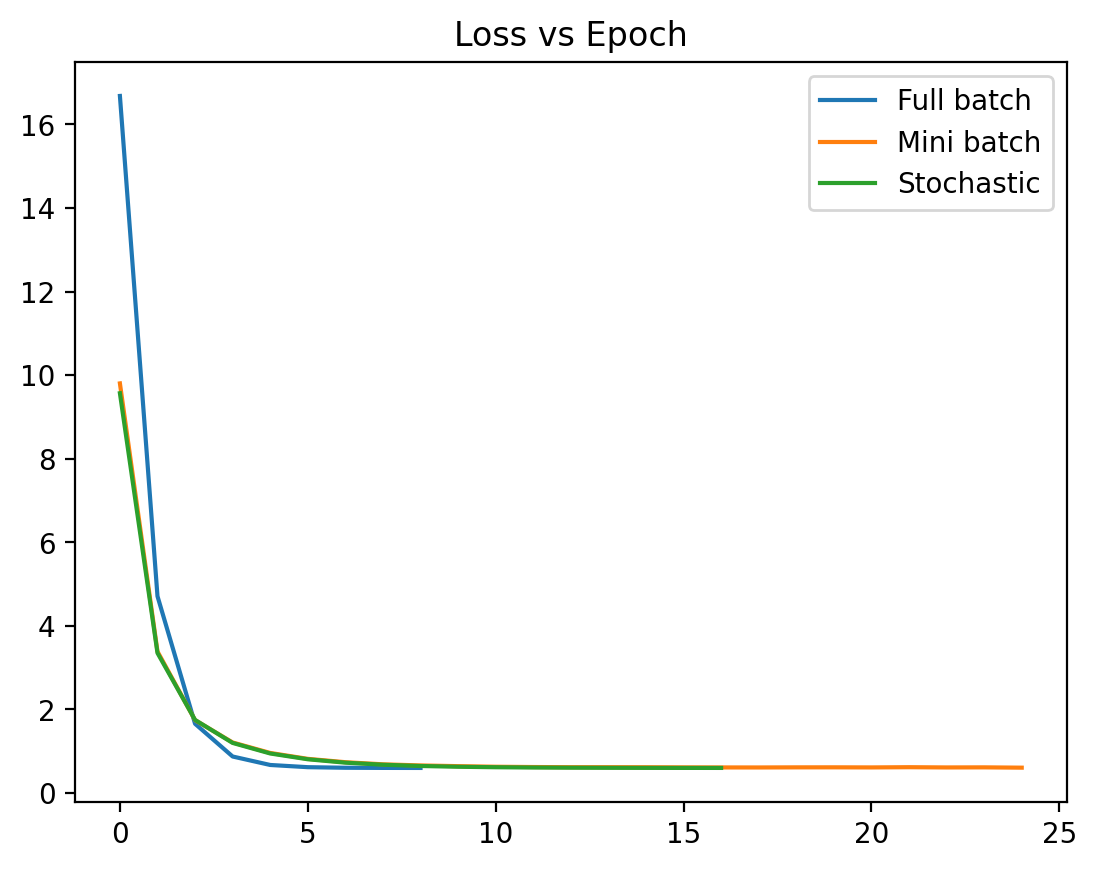

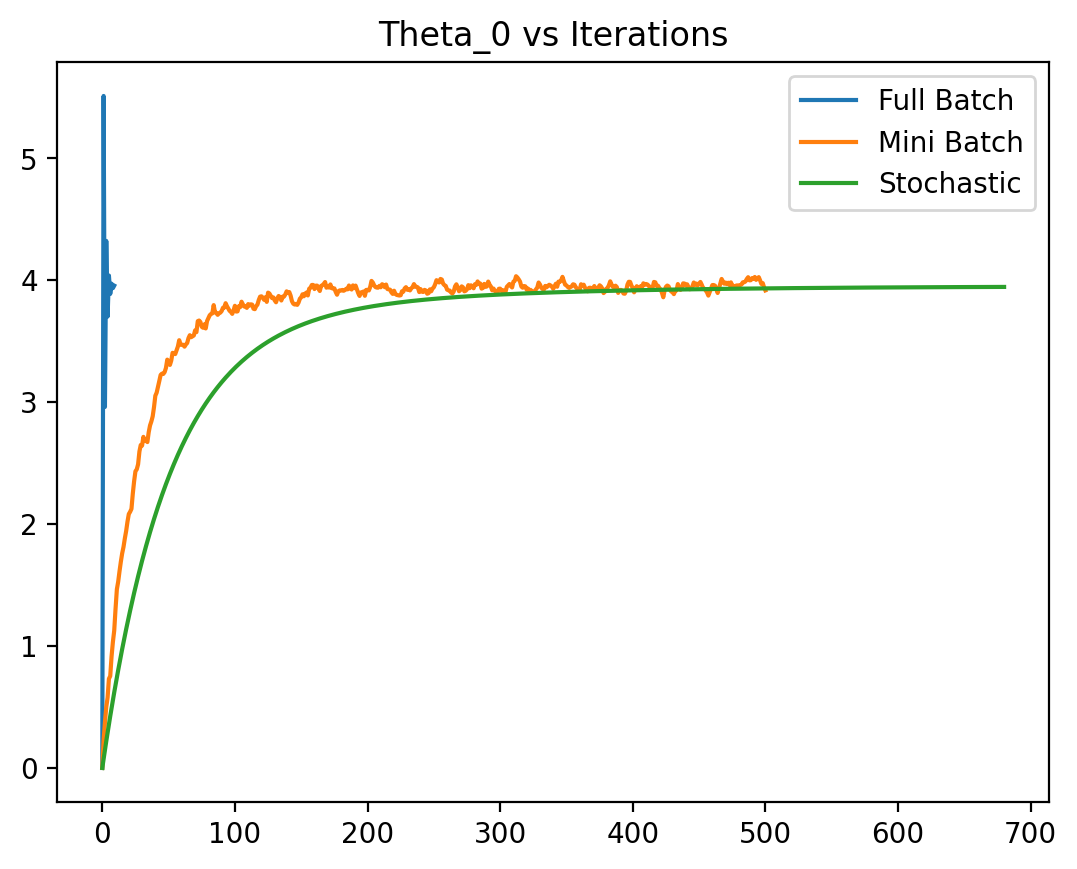

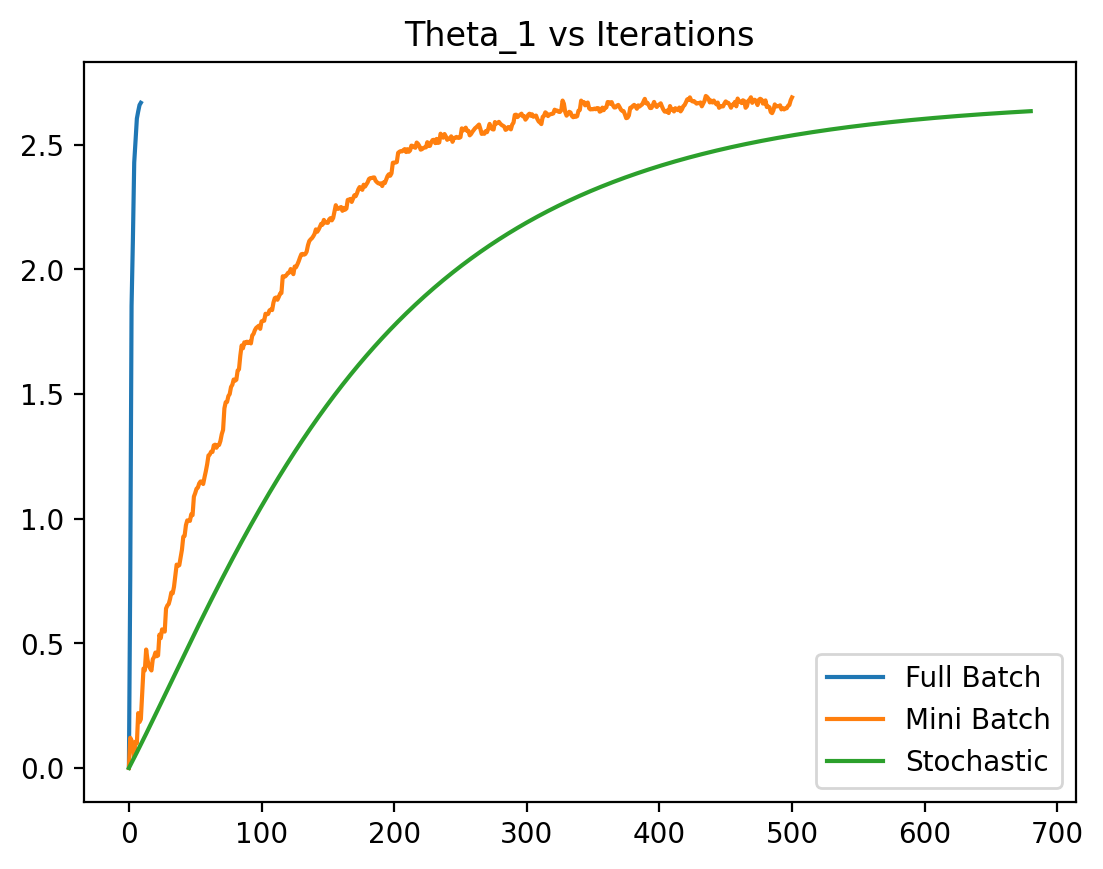

In [11]:
np.random.seed(45)
plt.plot(losses_full, label = 'Full batch')
plt.plot(losses_mini, label = 'Mini batch')
plt.plot(losses_stoc, label = 'Stochastic')
plt.legend()
plt.title('Loss vs Epoch')
plt.show()
plt.plot(t0_hist_full, label = 'Full Batch')
plt.plot(t0_hist_mini, label = 'Mini Batch')
plt.plot(t0_hist_stoc, label = 'Stochastic')
plt.legend()
plt.title('Theta_0 vs Iterations')
plt.show()
plt.plot(t1_hist_full, label = 'Full Batch')
plt.plot(t1_hist_mini, label = 'Mini Batch')
plt.plot(t1_hist_stoc, label = 'Stochastic')
plt.legend()
plt.title('Theta_1 vs Iterations')
plt.show()

#### Show the contour plots for different epochs (or show an animation/GIF) for visualisation of optimisation process

In [12]:
theta0_range = np.linspace(-2, 8, 100)
theta1_range = np.linspace(-1, 6, 100)
theta0_grid, theta1_grid = np.meshgrid(theta0_range, theta1_range)
loss_grid = np.zeros_like(theta0_grid)
for i in range(theta0_grid.shape[0]):
    for j in range(theta0_grid.shape[1]):
        y_hat = reg(x1_torch, theta0_grid[i,j], theta1_grid[i,j])
        loss_grid[i, j] = mse(y_hat, y_torch)

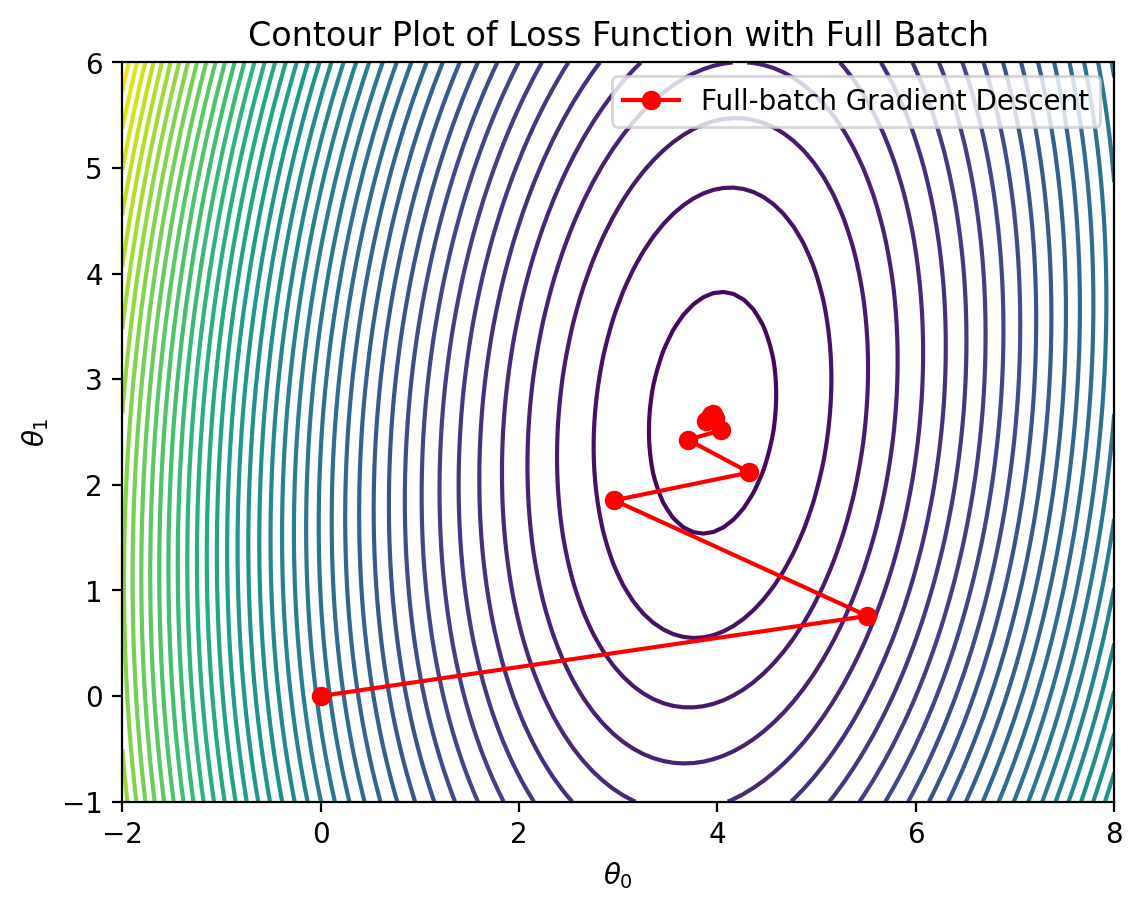

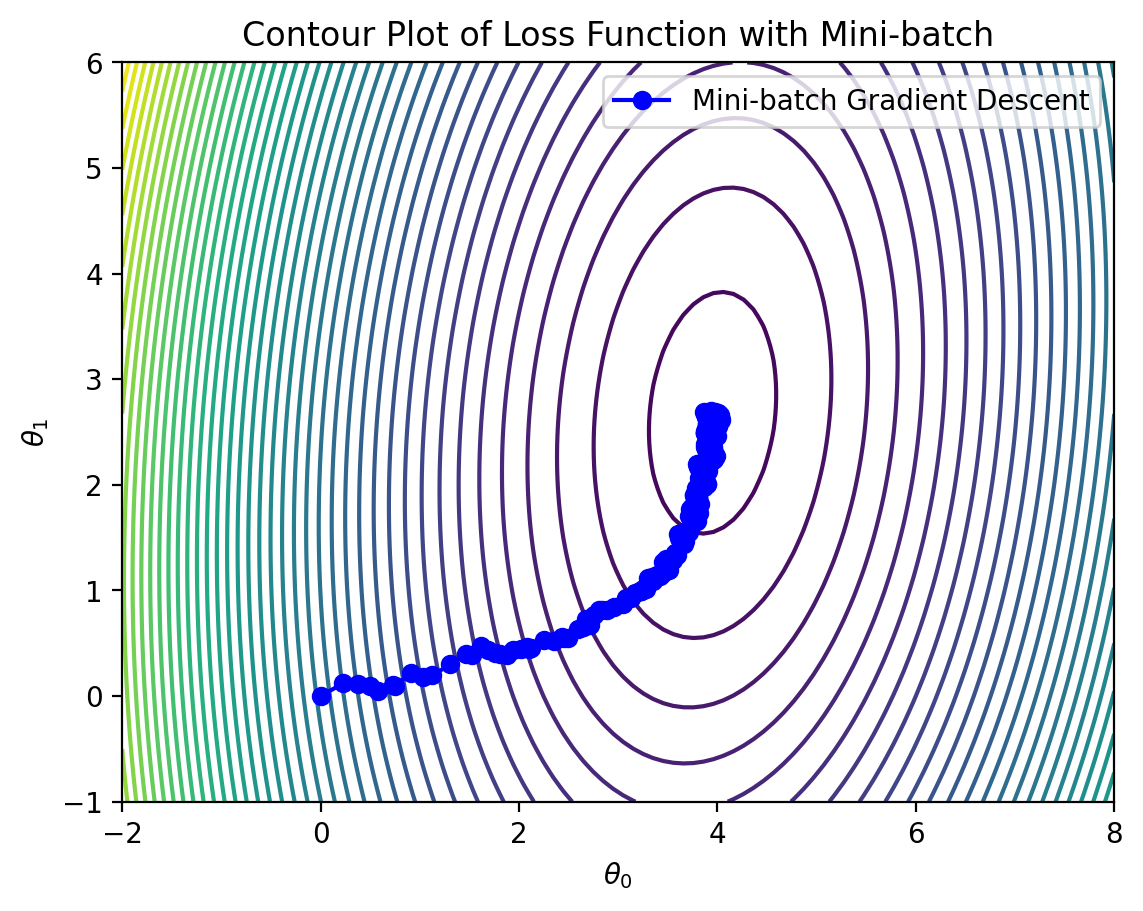

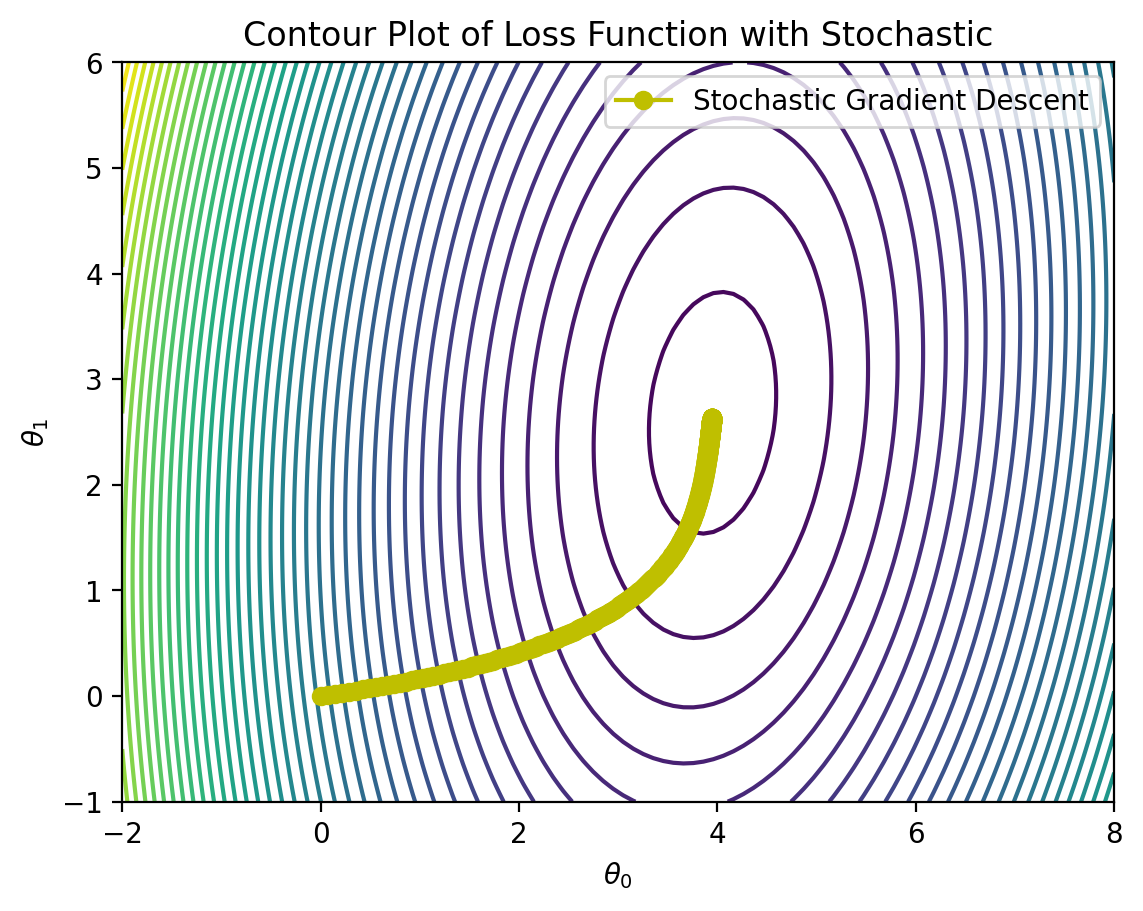

In [13]:
# plt.figure(figsize=(10, 6))
plt.contour(theta0_grid, theta1_grid, loss_grid, levels=50, cmap='viridis')
plt.plot(t0_hist_full, t1_hist_full, marker='o',color='r', label='Full-batch Gradient Descent')
# plt.plot(t0_hist_mini, t1_hist_mini, marker='o', label='Mini-batch Gradient Descent')
# plt.plot(t0_hist_stoc, t1_hist_stoc, marker='o', label='Stochastic Gradient Descent')

plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
plt.title('Contour Plot of Loss Function with Full Batch')
plt.legend()
plt.show()
# plt.figure(figsize=(10, 6))
plt.contour(theta0_grid, theta1_grid, loss_grid, levels=50, cmap='viridis')
plt.plot(t0_hist_mini, t1_hist_mini, marker='o', color='b', label='Mini-batch Gradient Descent')

plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
plt.title('Contour Plot of Loss Function with Mini-batch')
plt.legend()
plt.show()

# plt.figure(figsize=(10, 6))
plt.contour(theta0_grid, theta1_grid, loss_grid, levels=50, cmap='viridis')
plt.plot(t0_hist_stoc, t1_hist_stoc, marker='o', color='y', label='Stochastic Gradient Descent')

plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
plt.title('Contour Plot of Loss Function with Stochastic')
plt.legend()
plt.show()

In [14]:
# from matplotlib.animation import FuncAnimation
# fig, ax = plt.subplots(figsize=(10, 6))
# contour = ax.contour(theta0_grid, theta1_grid, loss_grid, levels=50, cmap='viridis')
# line, = ax.plot([], [], 'r-o', label='Gradient Descent Path')
# ax.set_xlabel(r'$\theta_0$')
# ax.set_ylabel(r'$\theta_1$')
# ax.set_title('Contour Plot of Loss Function with Optimization Path')
# ax.legend()
# def init():
#     line.set_data([], [])
#     return line,

# # Update function for the animation
# def update_full(i):
#     line.set_data(t0_hist_full[:i+1], t1_hist_full[:i+1])
#     return line,
# def update_mini(i):
#     line.set_data(t0_hist_mini[:i+1], t1_hist_mini[:i+1])
#     return line,
# def update_stoc(i):
#     line.set_data(t0_hist_stoc[:i+1], t1_hist_stoc[:i+1])
#     return line,

# # Create the animation
# ani = FuncAnimation(fig, update_full, frames=len(t0_hist_full), init_func=init, blit=True, repeat=False)
# ani.save('results/Full_batch_grad.gif', writer='imagemagick')
# ani = FuncAnimation(fig, update_mini, frames=len(t0_hist_mini), init_func=init, blit=True, repeat=False)
# ani.save('results/Mini_batch_grad.gif', writer='imagemagick')
# ani = FuncAnimation(fig, update_stoc, frames=len(t0_hist_stoc), init_func=init, blit=True, repeat=False)
# ani.save('results/Stochastic_grad.gif', writer='imagemagick')

## 1.4

Gradient descent with momentum 

In [23]:
def grad_momentum(x,y,theta_0,theta_1,lr = 0.01,epsilon = 0.001,epochs = 15,momentum = 0.03,printf = False,loss_opt = torch.tensor(0.5958, dtype=torch.float64)):
    # theta_0 = torch.tensor(0.0,requires_grad=True)
    # theta_1 = torch.tensor(0.0,requires_grad=True)
    t0_hist = [theta_0.item()]
    t1_hist = [theta_1.item()]
    losses = []
    epoch = 1
    loss = torch.tensor(float('inf'))
    change0 = 0
    change1 = 0
    if epochs is not None:
        while True:
            y_hat = reg(x,theta_0,theta_1)
            loss = mse(y_hat,y)
            losses.append(loss.item())
            loss.backward()
            with torch.no_grad():
                change0 = lr*theta_0.grad +momentum*change0
                change1 = lr*theta_1.grad +momentum*change1
                theta_0.data -= change0
                theta_1.data -= change1

            t0_hist.append(theta_0.item())
            t1_hist.append(theta_1.item())
            # print(f'Epoch:{epoch}--> Loss:{loss.item()}')
            theta_0.grad.zero_()
            theta_1.grad.zero_()
            epoch += 1
            if epoch>=epochs:
                break
            # if epoch>=400 and epoch%50 == 0:
            #     if losses[-5:].count(losses[-1])== 5:
            #         break
            # if len(losses) >2:
            #     if losses[-1]-losses[-2]<epsilon:
            #         break
    else:
        while True:
            y_hat = reg(x,theta_0,theta_1)
            loss = mse(y_hat,y)
            losses.append(loss.item())
            loss.backward()
            with torch.no_grad():
                change0 = lr*theta_0.grad +momentum*change0
                change1 = lr*theta_1.grad +momentum*change1
                theta_0.data -= change0
                theta_1.data -= change1

            t0_hist.append(theta_0.item())
            t1_hist.append(theta_1.item())
            # print(f'Epoch:{epoch}--> Loss:{loss.item()}')
            theta_0.grad.zero_()
            theta_1.grad.zero_()
            epoch += 1
            # if epoch>=400 and epoch%50 == 0:
            #     if losses[-5:].count(losses[-1])== 5:
            #         break
            if len(losses) >2:
                if abs(losses[-1]-loss_opt)<epsilon:
                    break
    if printf is True:
        print(f'Gradient Descent with Momentum---->No of Epochs Caliculated:{epoch} Final loss:{losses[-1]}')
    return losses, theta_0.grad.item(), theta_1.grad.item(),t0_hist,t1_hist

# losses_p, theta_0_p, theta_1_p, t0_hist_p, t1_hist_p = grad_momentum(x1_torch,y_torch,epochs=15,printf=True)

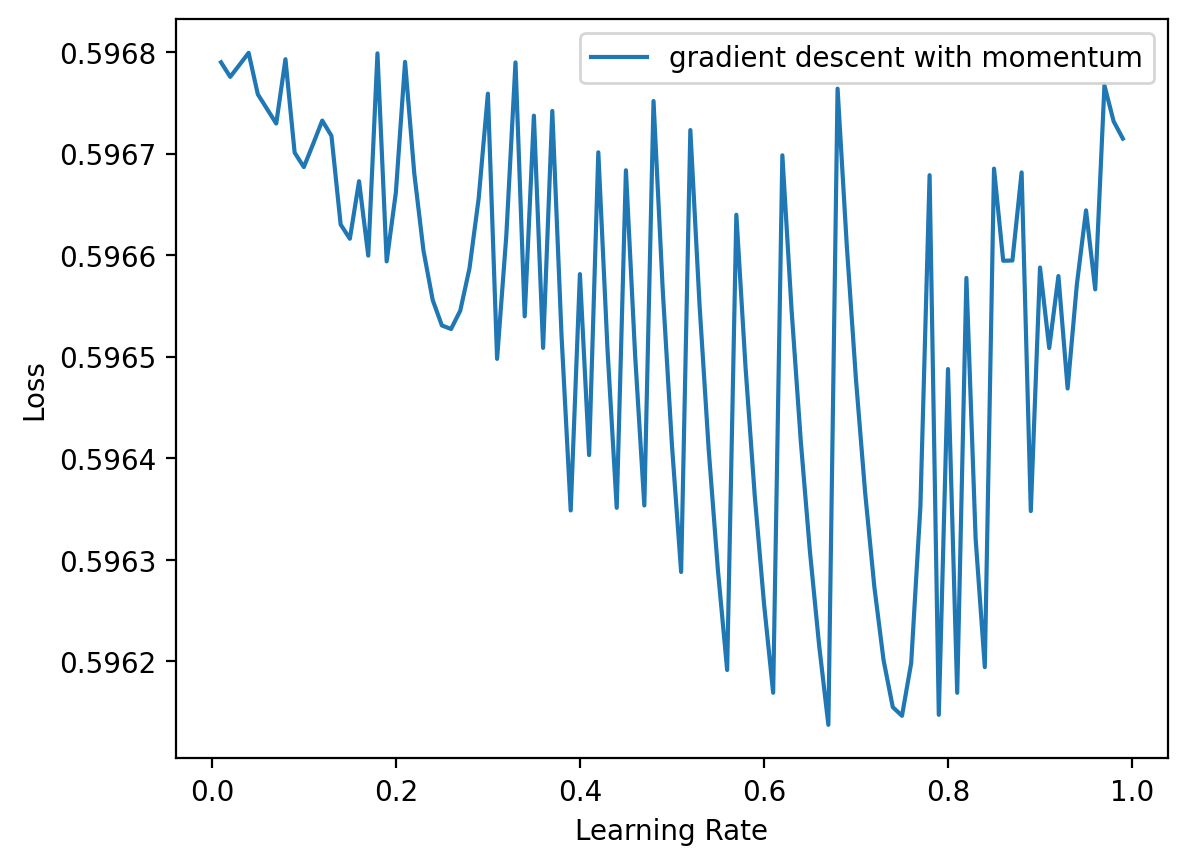

at Optimum lr:0.67, gradient descent with momentum has a loss of 0.5961375469593116


In [24]:
learning_rates = np.arange(0.01,1,0.01)
loss_p= []

for lr in learning_rates:
    theta_0 = torch.tensor(0.0,requires_grad=True)
    theta_1 = torch.tensor(0.0,requires_grad=True)
    # print(f'For learing rate {lr} :')
    losses_p,_,_,_,_= grad_momentum(x1_torch, y_torch,theta_0,theta_1,lr =lr,epochs = None)
    loss_p.append(losses_p[-1])

plt.plot(learning_rates,loss_p,label = 'gradient descent with momentum')
plt.legend()  
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.show()

p = np.argmin(loss_p)

opt_lr_p = learning_rates[p]

# print(learning_rates)
print(f'at Optimum lr:{learning_rates[p]}, gradient descent with momentum has a loss of {loss_p[p]}')

In [25]:
losses_p, theta_0_p, theta_1_p, t0_hist_p, t1_hist_p = grad_momentum(x1_torch,y_torch,theta_0 = torch.tensor(0.0,requires_grad=True),theta_1 = torch.tensor(0.0,requires_grad=True),epochs=15,lr= opt_lr_p,printf=True)

Gradient Descent with Momentum---->No of Epochs Caliculated:15 Final loss:0.5957554912672389


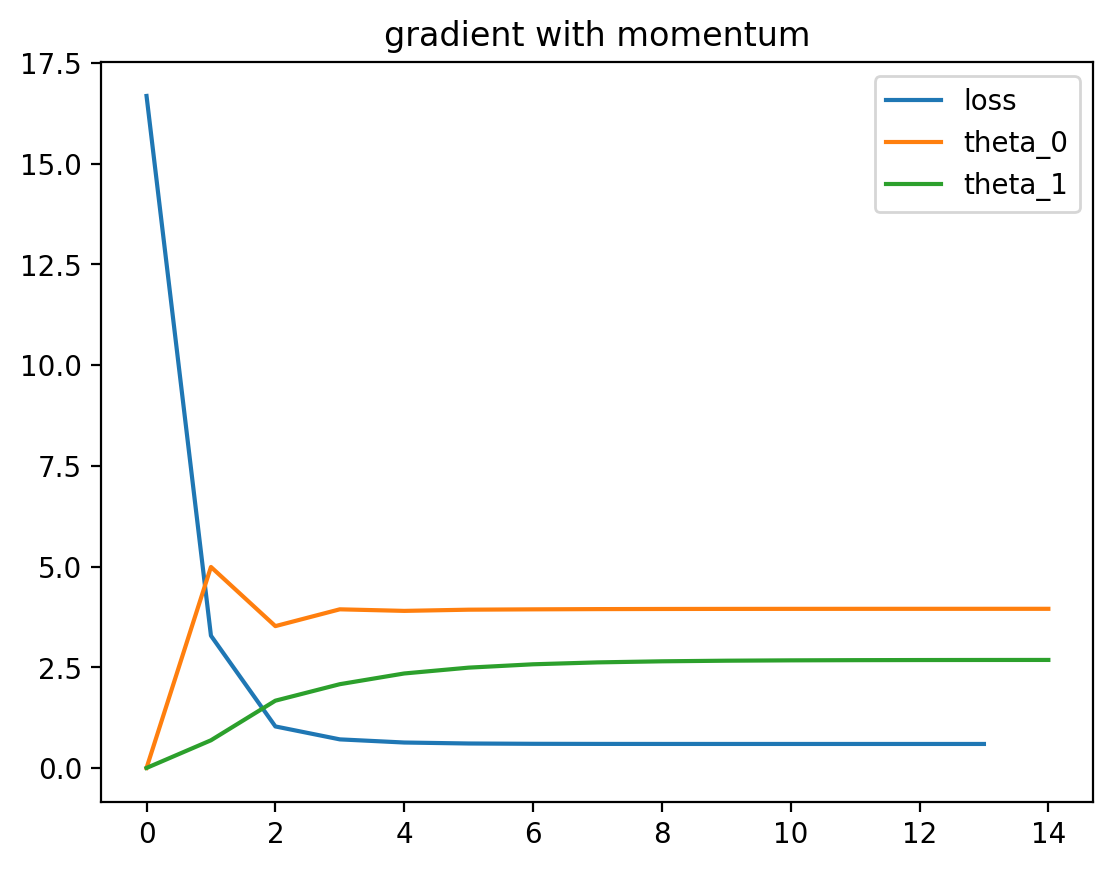

In [26]:
plt.plot(losses_p, label = 'loss')
plt.plot(t0_hist_p, label = 'theta_0')
plt.plot(t1_hist_p, label = 'theta_1')
plt.legend()
plt.title('gradient with momentum')
plt.show()

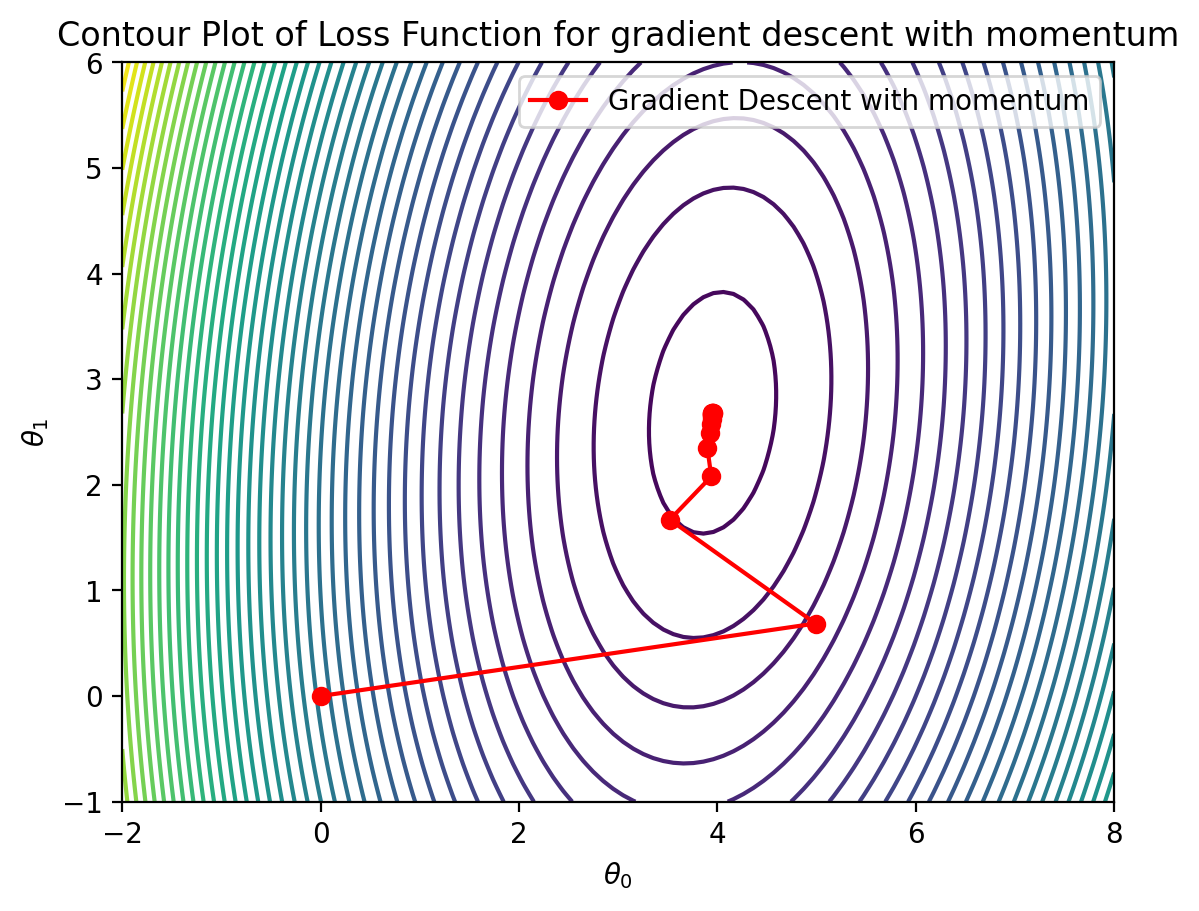

In [27]:
plt.contour(theta0_grid, theta1_grid, loss_grid, levels=50, cmap='viridis')
plt.plot(t0_hist_p, t1_hist_p, marker='o', color='r', label='Gradient Descent with momentum')
# plt.plot(t0_hist_full, t1_hist_full, marker='o', label='Full-batch Gradient Descent')
# plt.plot(t0_hist_mini, t1_hist_mini, marker='o', label='Mini-batch Gradient Descent')
# plt.plot(t0_hist_stoc, t1_hist_stoc, marker='o', label='Stochastic Gradient Descent')

plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
plt.title('Contour Plot of Loss Function for gradient descent with momentum')
plt.legend()
plt.show()

In [28]:
# def update_p(i):
#     line.set_data(t0_hist_p[:i+1], t1_hist_p[:i+1])
#     return line,
# ani = FuncAnimation(fig, update_p, frames=len(t0_hist_p), init_func=init, blit=True, repeat=False)
# ani.save('results/grad_momentum.gif', writer='imagemagick')

In [32]:
np.random.set_state(rs)
# Function to calculate the average number of iterations
def calculate_average_iterations(method, x, y, num_runs=100, lr=0.05, epsilon=0.001, epochs=None, batch_size=2):
    total_epochs = 0
    total_iterations = 0
    for _ in range(num_runs):
        rand_theta_0 = torch.tensor(np.random.rand()*100, requires_grad=True)
        rand_theta_1 = torch.tensor(np.random.rand()*100, requires_grad=True)
        # print(rand_theta_0,rand_theta_1)
        if method == 'full_batch':
            losses, _, _, _, t1_hist = full_batch_grad(x, y,rand_theta_0,rand_theta_1, lr, epsilon=epsilon, epochs=epochs)
        elif method == 'mini_batch':
            losses, _, _, _, t1_hist = mini_batch_grad(x, y,rand_theta_0,rand_theta_1, lr, batch_size=batch_size, epsilon=epsilon, epochs=epochs)
        elif method == 'stochastic':
            losses, _, _, _, t1_hist = stochastic_grad(x, y,rand_theta_0,rand_theta_1, lr, epsilon=epsilon, epochs=epochs)
        elif method == 'momentum':
            losses, _, _, _, t1_hist = grad_momentum(x, y,rand_theta_0,rand_theta_1, lr, epsilon=epsilon, epochs=epochs)
        else:
            raise ValueError("Unknown method")

        # Get the number of iterations from the length of the losses array
        total_epochs += len(losses)
        total_iterations += len(t1_hist)
        # print(losses)

    # Calculate the average number of iterations
    average_epochs = total_epochs / num_runs
    average_iterations = total_iterations / num_runs
    return average_epochs, average_iterations



# Example usage
# Assuming you have x and y tensors defined and loaded with data

num_runs = 100
avg_epochs_p,avg_iters_p = calculate_average_iterations('momentum', x1_torch, y_torch, num_runs,opt_lr_p)

print(f"To converge, Average Epochs for Full Batch Gradient Descent: {avg_epochs_full} and average iterations required: {avg_iters_full_batch}")
print(f"To converge, Average Epochs for Mini Batch Gradient Descent: {avg_epochs_mini} and average iterations required: {avg_iters_mini_batch}")
print(f"To converge, Average Epochs for Stochastic Gradient Descent: {avg_epochs_stoc} and average iterations required: {avg_iters_stochastic}")
print(f"To converge, Average Epochs for Full Batch Gradient Descent: {avg_epochs_p} and average iterations required: {avg_iters_p}")

To converge, Average Epochs for Full Batch Gradient Descent: 12.86 and average iterations required: 13.86
To converge, Average Epochs for Mini Batch Gradient Descent: 28.45 and average iterations required: 570.0
To converge, Average Epochs for Stochastic Gradient Descent: 17.0 and average iterations required: 681.0
To converge, Average Epochs for Full Batch Gradient Descent: 13.17 and average iterations required: 14.17


In [33]:
print(f'The value of gradient of theta0,theta1 respectively are [{theta_0_p}, {theta_1_p}]')
print(f'The value of theta0,theta1 respectively are [{t0_hist_p[-1]}, {t1_hist_p[-1]}]')
print(f'The final change values used is {t0_hist_p[-1]-t0_hist_p[-2]},{t1_hist_p[-1]-t1_hist_p[-2]}')


The value of gradient of theta0,theta1 respectively are [0.0, 0.0]
The value of theta0,theta1 respectively are [3.9505627155303955, 2.681290864944458]
The final change values used is 0.00010943412780761719,0.0008966922760009766
